# 4.1 Neural Networks - Single Perceptron

A linear regression is a single, fully connected neuron.

![Single Neuron](./figures/TLU.png)

The simplest neural network is a logistic regression

$y = f( \sum_{i=1}^3  (w_i x_i + b_i))$,

where $y$ is the output, $w_i$, are the weights, $b_i$ are the biases in the neuron, and $f$ is an activation function (e.g., sigmoid, ReLu, etc)

For classification problem, it is called a Threshold Logic Unit TLU because it outputs a linear combination of the inputs, and if the result exceeds a threshold, it outputs the positive class.

A perceptron is a single layer of TLUs, which each TLU connected to all the inputs. 

**Logistic regression: It is just a one layer neural network classifier**

We will explore the classification problem with NN.


In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np

## Load a data set

We will read a dataset and convert into a format readable by PyTorch.

We are going to do multi-class classification. We have a dataset of images of digits (0 to 9). Each image is made of 16 * 16 pixels in grey scale. 

In [2]:
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_digits,fetch_openml
from sklearn.preprocessing import StandardScaler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import transforms, ToTensor, Compose,Normalize
from sklearn.model_selection import train_test_split
from torchvision import datasets

dataset = datasets.MNIST(root="./",download=True,
 transform=Compose([ToTensor(),Normalize([0.5],[0.5])]))
L=len(dataset)
Lt = int(0.8*L)

train_set, val_set = torch.utils.data.random_split(dataset, [Lt,L-Lt])
loaded_train = DataLoader(train_set, batch_size=50)
loaded_test = DataLoader(val_set, batch_size=50)
print(loaded_train)

X, y = next(iter(loaded_train))
print(X.shape)

torch.Size([50, 1, 28, 28])


In [3]:
X.shape

torch.Size([50, 1, 28, 28])

A second  approach is to prepare the data from zip files and convert them to torch tensors. The training file and the test file are made of 257 columns: the first column is the label, the next 256 columns are the corresponding value for each of the 16 * 16 = 256 pixels. There is one image per row.

In [3]:
# Dataset is a class already defined in PyTorch. 
# We are going to create a subclass of Dataset
class ZipDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        # Let us define the attributes of a ZipDataset
        self.X = images # that will be train_images or test_images
        self.y = labels # that will be train_labels or test_labels
        # When we create an object of class ZipDataset, we can specify the transformation to apply to the data 
        self.transforms = transforms
         
    def __len__(self):
        # The length of the dataset is the number of images in the dataset
        return (len(self.X))
    
    def __getitem__(self, i):
        # How to access one pair of (image, label) from the dataset?
        # We access the ith row (which contains the 16*16 = 256 pixels of an image)
        data = self.X.iloc[i, :]
        # We tranform it into a numpy array and reshape it to an image format
        data = np.asarray(data).reshape(16, 16, 1)
        # We apply the required transformation to the image
        if self.transforms:
            data = self.transforms(data)
        # If there is a label associated to it, we return it together with the image
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [4]:
df_train = pd.read_csv('zip.train', header=None, sep='\s+')
df_test = pd.read_csv('zip.test', header=None, sep='\s+')
train_labels = df_train.iloc[:, 0]
#train_images = df_train.iloc[:, 1:]
train_images = df_train.iloc[:100, 1:]

test_labels = df_test.iloc[:, 0]
#test_images = df_test.iloc[:, 1:]
test_images = df_test.iloc[:100, 1:]

train_data = ZipDataset(train_images, train_labels, ToTensor())
test_data = ZipDataset(test_images, test_labels, ToTensor())

In [5]:
print(train_data)
print(train_images)

    1    2    3      4      5      6      7      8      9      10   ...  \
0  -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -0.631  0.862 -0.167  ...   
1  -1.0 -1.0 -1.0 -0.813 -0.671 -0.809 -0.887 -0.671 -0.853 -1.000  ...   
2  -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -0.996  ...   
3  -1.0 -1.0 -1.0 -1.000 -1.000 -0.273  0.684  0.960  0.450 -0.067  ...   
4  -1.0 -1.0 -1.0 -1.000 -1.000 -0.928 -0.204  0.751  0.466  0.234  ...   
..  ...  ...  ...    ...    ...    ...    ...    ...    ...    ...  ...   
95 -1.0 -1.0 -1.0 -1.000 -1.000 -0.539 -0.016 -0.903 -1.000 -1.000  ...   
96 -1.0 -1.0 -1.0 -1.000 -1.000 -0.934 -0.861 -0.673 -0.302 -0.000  ...   
97 -1.0 -1.0 -1.0 -1.000 -1.000 -0.326  0.648  1.000  0.972 -0.006  ...   
98 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000  0.222  0.803  ...   
99 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -1.000 -1.000 -0.749 -0.085  ...   

      247    248    249    250    251    252    253    254    255  256  
0   0.304  0.823  1.000  0

Pytorch uses a class to manipulate Datasets called [DataLoader](https://pytorch.org/docs/stable/data.html). It has methods such as iteration, indexing, mini-batching, sampler.

In [6]:
trainloader = DataLoader(train_data)
testloader = DataLoader(test_data)

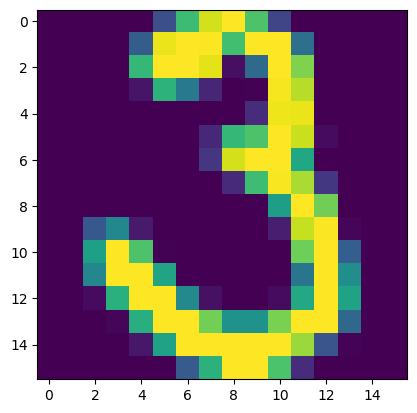

In [7]:
exampleDigit=train_data[75][0].numpy()[0]
plt.imshow(exampleDigit)

## a. Design Model

The first neural networks we will create is a single neuron that takes the images as input and output the probability in each of the 10 classes.

In [8]:
# We create a subclass of neural networks: 
# #This one will just have one layer

class NN1(nn.Module): # a class defines an object


    # this defines the arcitecture of the NN
    def __init__(self, size_img, num_classes):
        # Here we define all the functions that we will use during the forward part (data -> prediction)
        
        # super means that the model will inherit all of the methods
        super(NN1, self).__init__()



        self.flatten = nn.Flatten() # go from a 16*16 tensor to a 256*1 tensor
        self.size_img = size_img # number of pixels in an image
        self.layer1 = nn.Linear(size_img, num_classes) # y = wx + b with w = 10*256 (10 digits * 256 pixels), applying the linear operation of this layer


    # this defines how the data passes through the layers
    def forward(self, x):
        # Here we explain in which order to use the functions defined above
        x = self.flatten(x)
        logits = self.layer1(x)
        return logits

We now create a model of the class NN1.

In [11]:
model = NN1(16*16, 10) #instead of 28 x 28

In [12]:
print(model)

NN1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=256, out_features=10, bias=True)
)


## b. Define Loss Function

For the binary classification, we had defined the logistic function or *sigmoid* function as,

$\hat{y} = \frac{1}{1 + e^{-z}}$,
 
as the probability function for a binary classifier.

The log loss function to minimize is:

$\mathcal{L} =  - (y \log \hat{y} + (1 - y) \log (1 - \hat{y})$ with $\hat{y} = \frac{1}{1 + e^{-z}}$.

We wanted to find all of the weights $w$ and biases $b$ such that $P(Y = y)$ is maximum, which is equivalent to minimizing the loss $\mathcal{L}$.

For a multi-class classification, $k$ being the class and $K$ the number of classes, the sigmoid function is extended to a *softmax function*,

$P(Y = k) = \frac{\exp(w_k x + b_k)}{\sum_{j = 1}^K \exp(w_j x + b_j)}$

Once we have found the values of the $w_k$ and $b_k$ for $k = 1 , \cdots , K$, we can compute the values of the $P(Y = k)$. We then look for which value of $k$ $P(Y = k)$ is maximal and we classify this sample as class $k$.


Similarly, we define the loss with $K$ classes:

$\mathcal{L} = - \sum_{k = 1}^K y_k \log \frac{\exp(w_k x + b_k)}{\sum_{j = 1}^K \exp(w_j x + b_j)}$. We have $y_k = 1$ if the true label associated with the sample $x$ is $k$, otherwise $y_k = 0$.

This is called the _cross-entropy loss_.

In [13]:
nn.CrossEntropyLoss()

CrossEntropyLoss()

## c. Define optimization

*Gradient descent* uses the entire data set to compute the gradient and find the optimal (minimum loss) solution. Effectively, the batch size is the entire data set.

*Mini batch gradient descent* uses batches of data to compute the gradient, find a solution, and moves to the next set of training data. The batch size is determined. The prediction on the training set is calculated for each sample in the batch, then averaged. Then the gradient is calculated.

*Stochastic gradient descrent* uses one data sample to calculate the gradient, finds a solution, then take another training sample to go down the gradient. Effectively, the batch size is 1.


In this example, we will use stochastic gradient descent SGD.

Parameters to choose are:
* optimizer (gradient descent or others)
* learning rate (scale to jump with the gradient)

In [14]:
learning_rate=0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## c. Define a training strategy

Parameters to choose are:
* **batch size**: this is the size of an individial training set used to estimate an average model prediction loss, after which a gradient will be calculated, and the model weights updated.
* **number of epochs**: this is the number of times the training goes over the *entire* data sets. If the training set is split into batches of size ``batch_size``, then at each **epoch**, the training will be performed over all batches. Models tend to be trained over multiple-to-many epochs (10,100,1000). 

Let us now define how to train the model. We will create a function for that.

In [15]:
def train(model, n_epochs, trainloader, testloader=None,learning_rate=0.001 ):

    # Define loss and optimization method
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)

    # # Loop on number of epochs
    for epoch in range(n_epochs):
    #     # Initialize the loss
        running_loss = 0
    #     # Loop on samples in train set
        for data in trainloader:
    #         # Get the sample and modify the format for PyTorch
            inputs, labels = data[0], data[1]
            inputs = inputs.float()
            print(inputs.shape)
            labels = labels.long()
    #         # Set the parameter gradients to zero
            optimizer.zero_grad()
            print(labels)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    #         # Propagate the loss backward
            loss.backward()
    #         # Update the gradients
            optimizer.step()
    #         # Add the value of the loss for this sample
            running_loss += loss.item()
    #     # Save loss at the end of each epoch
        loss_time[epoch] = running_loss/len(trainloader)

    #     # After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
    #         # We evaluate the model, so we do not need the gradient
            with torch.no_grad(): # Context-manager that disabled gradient calculation.
    #             # Loop on samples in test set
                for data in testloader:
    #                 # Get the sample and modify the format for PyTorch
                    inputs, labels = data[0], data[1]
                    inputs = inputs.float() 
                    labels = labels.long()
    #                 # Use model for sample in the test set
                    outputs = model(inputs)
    #                 # Compare predicted label and true label
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
    #         # Save error at the end of each epochs
            accuracy_time[epoch] = 100 * correct / total
    
    #     # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
              (epoch + 1, running_loss/len(trainloader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader)))

    # # Save history of loss and test error
    if testloader is not None:
        return (loss_time, accuracy_time)
    else:
        return (loss_time)

In [16]:
(loss, accuracy) = train(model, 10,trainloader, testloader, learning_rate)
#(loss, accuracy) = train(model, 10,loaded_train, loaded_test)

torch.Size([1, 1, 16, 16])
tensor([6])
torch.Size([1, 1, 16, 16])
tensor([5])
torch.Size([1, 1, 16, 16])
tensor([4])
torch.Size([1, 1, 16, 16])
tensor([7])
torch.Size([1, 1, 16, 16])
tensor([3])
torch.Size([1, 1, 16, 16])
tensor([6])
torch.Size([1, 1, 16, 16])
tensor([3])
torch.Size([1, 1, 16, 16])
tensor([1])
torch.Size([1, 1, 16, 16])
tensor([0])
torch.Size([1, 1, 16, 16])
tensor([1])
torch.Size([1, 1, 16, 16])
tensor([7])
torch.Size([1, 1, 16, 16])
tensor([0])
torch.Size([1, 1, 16, 16])
tensor([1])
torch.Size([1, 1, 16, 16])
tensor([1])
torch.Size([1, 1, 16, 16])
tensor([7])
torch.Size([1, 1, 16, 16])
tensor([7])
torch.Size([1, 1, 16, 16])
tensor([4])
torch.Size([1, 1, 16, 16])
tensor([8])
torch.Size([1, 1, 16, 16])
tensor([0])
torch.Size([1, 1, 16, 16])
tensor([1])
torch.Size([1, 1, 16, 16])
tensor([4])
torch.Size([1, 1, 16, 16])
tensor([8])
torch.Size([1, 1, 16, 16])
tensor([7])
torch.Size([1, 1, 16, 16])
tensor([4])
torch.Size([1, 1, 16, 16])
tensor([8])
torch.Size([1, 1, 16, 16]

Let us now plot the evolution of the loss and the percentage of correct predictions with time:

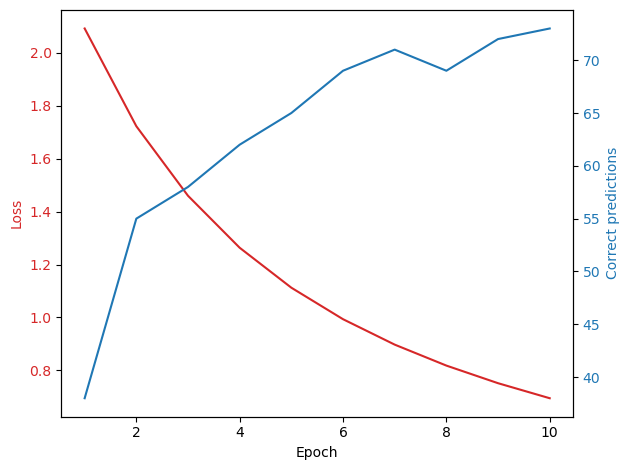

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, 11), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, 11), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()